<a href="https://colab.research.google.com/github/rcpaffenroth/dac_raghu/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

import json

In [8]:
name = 'MNIST'
# Read the json info file
with open(f'4-data/info.json') as f:
    info = json.load(f)
# Read the start data
x_start = pd.read_parquet(f'4-data/{name}_start.parquet')
# Read the target data
x_target = pd.read_parquet(f'4-data/{name}_target.parquet')


# Dynamical system

In [9]:
x_size = x_start.shape[1]

# # A pytorch module that multiplies the output of two other modules, where the two modules are given as arguments to the constructor, and the fo
# # The forward method takes a single argument and returns a single tensor.
# class Multiply(nn.Module):
#     def __init__(self, module1, module2):
#         super().__init__()
#         self.module1 = module1
#         self.module2 = module2
#     def forward(self, x):
#         return self.module1(x) * self.module2(x)

# map = Multiply(nn.Linear(x_size, x_size), nn.Linear(x_size, x_size)) 

map = nn.Sequential(nn.Linear(x_size, x_size), nn.LeakyReLU(), nn.Linear(x_size, x_size))

In [10]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Make two pytorch tensor datasets from the start and target data
x_start_tensor = df_to_tensor(x_start)
x_target_tensor = df_to_tensor(x_target)

x_start_tensor_test = x_start_tensor[:1000]
x_target_tensor_test = x_target_tensor[:1000]

x_start_tensor = x_start_tensor[1000:6000]
x_target_tensor = x_target_tensor[1000:6000]

# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, x_start, x_target):
        self.x_start = x_start
        self.x_target = x_target
    def __len__(self):
        return len(self.x_start)
    def __getitem__(self, idx):
        return self.x_start[idx], self.x_target[idx]
    
train_data = Data(x_start_tensor, x_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [11]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RAdam(map.parameters())

In [12]:
max_epochs = 500
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        mapped = map(start)
        loss = criterion(mapped, target)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 49, Loss 0.0791342705488205


Epoch 100, Batch 49, Loss 0.00034728326136246324
Epoch 200, Batch 49, Loss 0.0003137897583656013
Epoch 300, Batch 49, Loss 0.00020032750035170466
Epoch 400, Batch 49, Loss 0.0001049509592121467


# Training data

In [13]:
plot_idx = 2
mapped_tensor = map(x_start_tensor).detach()
print('before: ', x_start_tensor[plot_idx][-1])
print('after:  ', mapped_tensor[plot_idx][-1])
print('truth:  ', x_target_tensor[plot_idx][-1])



before:  tensor(9.)
after:   tensor(0.9672)
truth:   tensor(1.)


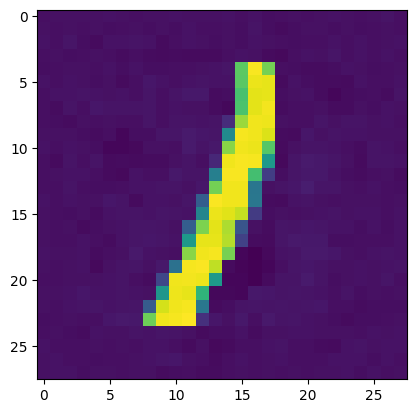

In [14]:
plt.figure()
plt.imshow(mapped_tensor[plot_idx][:-1].reshape(28, 28).numpy())

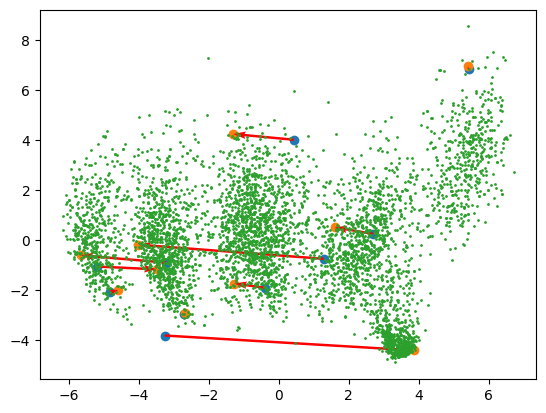

In [15]:
mapped_tensor = map(x_start_tensor).detach()
plot_points = 10

from sklearn.decomposition import PCA


def plot_tensor_projections(x_start_tensor, mapped_tensor, x_target_tensor, plot_points):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt


    pca = PCA(n_components=2)
    pca.fit(x_target_tensor)
    # Project tensors to 2D using PCA
    x_start_tensor_2 = pca.transform(x_start_tensor)[:plot_points]
    mapped_tensor_2 = pca.transform(mapped_tensor)[:plot_points]
    x_target_tensor_2 = pca.transform(x_target_tensor)

    # Plot the 2D PCA projections and arrows
    fig, ax = plt.subplots()
    ax.scatter(x_start_tensor_2[:,0], x_start_tensor_2[:,1])
    ax.scatter(mapped_tensor_2[:,0], mapped_tensor_2[:,1])
    dx = mapped_tensor_2[:,0]-x_start_tensor_2[:,0]
    dy = mapped_tensor_2[:,1]-x_start_tensor_2[:,1]
    ax.quiver(x_start_tensor_2[:,0], x_start_tensor_2[:,1], dx, dy, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)
    ax.scatter(x_target_tensor_2[:,0], x_target_tensor_2[:,1], s=1)
    plt.show()

# Plot the 2D PCA projections and arrows for the three tensors
plot_tensor_projections(x_start_tensor, mapped_tensor, x_target_tensor, plot_points)

# Testing data

## Testing label

In [16]:
plot_idx = 2
test_tensor = x_start_tensor[plot_idx]
test_truth = x_target_tensor[plot_idx][-1]


for i in range(10):
    test_tensor[-1] = i
    mapped_tensor = map(test_tensor).detach()
    print('before: ', test_tensor[-1], 'after:  ', mapped_tensor[-1], 'truth: ', test_truth)


before:  tensor(0.) after:   tensor(1.1121) truth:  tensor(1.)
before:  tensor(1.) after:   tensor(1.1267) truth:  tensor(1.)
before:  tensor(2.) after:   tensor(1.1413) truth:  tensor(1.)
before:  tensor(3.) after:   tensor(1.1449) truth:  tensor(1.)
before:  tensor(4.) after:   tensor(1.1292) truth:  tensor(1.)
before:  tensor(5.) after:   tensor(1.1144) truth:  tensor(1.)
before:  tensor(6.) after:   tensor(1.0974) truth:  tensor(1.)
before:  tensor(7.) after:   tensor(1.0713) truth:  tensor(1.)
before:  tensor(8.) after:   tensor(1.0262) truth:  tensor(1.)
before:  tensor(9.) after:   tensor(0.9672) truth:  tensor(1.)


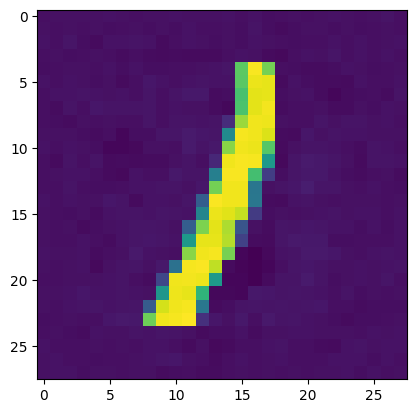

In [17]:
plt.figure()
plt.imshow(mapped_tensor[:-1].reshape(28, 28).numpy())

In [18]:
plot_idx = 155
test_tensor = x_start_tensor[plot_idx]
test_truth = x_target_tensor[plot_idx][-1]

for i in range(10):
    test_tensor[-1] = i
    mapped_tensor = map(map(test_tensor)).detach()
    print('before: ', test_tensor[-1], 'after:  ', mapped_tensor[-1], 'truth: ', test_truth)

before:  tensor(0.) after:   tensor(2.2391) truth:  tensor(2.)
before:  tensor(1.) after:   tensor(2.2376) truth:  tensor(2.)
before:  tensor(2.) after:   tensor(2.2358) truth:  tensor(2.)
before:  tensor(3.) after:   tensor(2.2385) truth:  tensor(2.)
before:  tensor(4.) after:   tensor(2.2413) truth:  tensor(2.)
before:  tensor(5.) after:   tensor(2.2439) truth:  tensor(2.)
before:  tensor(6.) after:   tensor(2.2469) truth:  tensor(2.)
before:  tensor(7.) after:   tensor(2.2497) truth:  tensor(2.)
before:  tensor(8.) after:   tensor(2.2527) truth:  tensor(2.)
before:  tensor(9.) after:   tensor(2.2557) truth:  tensor(2.)


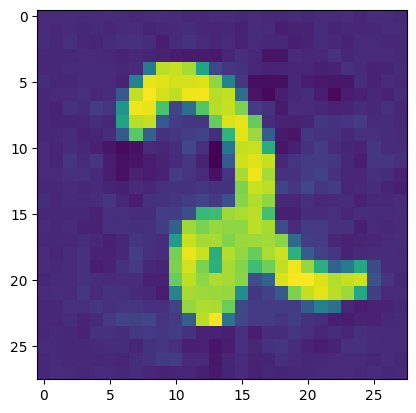

In [19]:
plt.figure()
plt.imshow(mapped_tensor[:-1].reshape(28, 28).numpy())

## Testing everything

In [20]:
plot_idx = 0
test_tensor = x_start_tensor_test[plot_idx]
test_truth = x_target_tensor_test[plot_idx][-1]

for i in range(10):
    test_tensor[-1] = i
    mapped_tensor = map(map(test_tensor)).detach()
    print('before: ', test_tensor[-1], 'after:  ', mapped_tensor[-1], 'truth: ', test_truth)

before:  tensor(0.) after:   tensor(7.2970) truth:  tensor(7.)
before:  tensor(1.) after:   tensor(7.2993) truth:  tensor(7.)
before:  tensor(2.) after:   tensor(7.3002) truth:  tensor(7.)
before:  tensor(3.) after:   tensor(7.3025) truth:  tensor(7.)
before:  tensor(4.) after:   tensor(7.3055) truth:  tensor(7.)
before:  tensor(5.) after:   tensor(7.3086) truth:  tensor(7.)
before:  tensor(6.) after:   tensor(7.3102) truth:  tensor(7.)
before:  tensor(7.) after:   tensor(7.3060) truth:  tensor(7.)
before:  tensor(8.) after:   tensor(7.3020) truth:  tensor(7.)
before:  tensor(9.) after:   tensor(7.3015) truth:  tensor(7.)


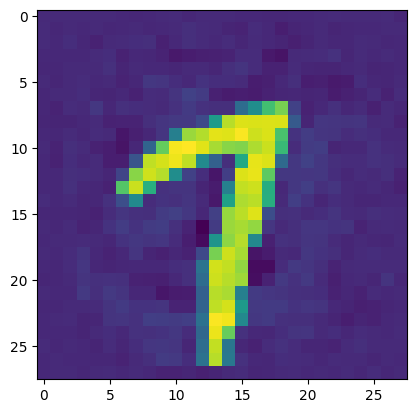

In [21]:
plt.figure()
plt.imshow(mapped_tensor[:-1].reshape(28, 28).numpy())

In [22]:
plot_idx = 1
test_tensor = x_start_tensor_test[plot_idx]
test_truth = x_target_tensor_test[plot_idx][-1]

for i in range(10):
    test_tensor[-1] = i
    mapped_tensor = map(map(test_tensor)).detach()
    print('before: ', test_tensor[-1], 'after:  ', mapped_tensor[-1], 'truth: ', test_truth)

before:  tensor(0.) after:   tensor(5.8773) truth:  tensor(6.)
before:  tensor(1.) after:   tensor(5.8697) truth:  tensor(6.)
before:  tensor(2.) after:   tensor(5.8613) truth:  tensor(6.)
before:  tensor(3.) after:   tensor(5.8532) truth:  tensor(6.)
before:  tensor(4.) after:   tensor(5.8441) truth:  tensor(6.)
before:  tensor(5.) after:   tensor(5.8357) truth:  tensor(6.)
before:  tensor(6.) after:   tensor(5.8270) truth:  tensor(6.)
before:  tensor(7.) after:   tensor(5.8147) truth:  tensor(6.)
before:  tensor(8.) after:   tensor(5.8018) truth:  tensor(6.)
before:  tensor(9.) after:   tensor(5.7887) truth:  tensor(6.)


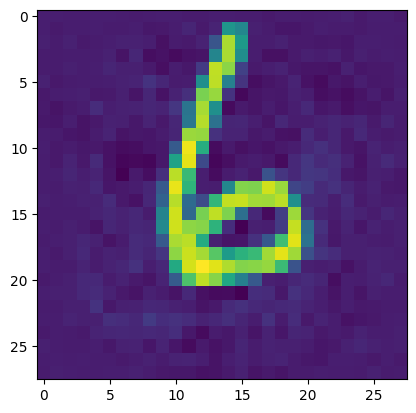

In [23]:
plt.figure()
plt.imshow(mapped_tensor[:-1].reshape(28, 28).numpy())